## Load library

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from scipy import stats
from scipy.signal import find_peaks

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(1)

Using TensorFlow backend.


In [82]:
from keras.wrappers.scikit_learn import KerasRegressor

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

In [3]:
from pickle import dump

## Data preprocessing

In [4]:
data = pd.read_csv('creditcard.csv')
data = data.drop(columns=['Time'])
# data = data.sample(frac = 0.1 ,random_state=1)
print(data.isnull().values.any())

data

False


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
data_scale = preprocessing.MinMaxScaler().fit_transform(data.values)
y = data["Class"].values
X_normal, X_fraud = data_scale[y == 0], data_scale[y == 1]
Y_normal, Y_fraud = np.zeros(X_normal.shape[0]), np.ones(X_fraud.shape[0])

In [7]:
outlier_fraction = len(Y_fraud)/float(len(Y_normal))
print(outlier_fraction)
print("Fraud Cases : {}".format(len(Y_fraud)))
print("Valid Cases : {}".format(len(Y_normal)))

0.0017304750013189597
Fraud Cases : 492
Valid Cases : 284315


In [8]:
# X_train_all, X_test_all, Y_train_all, Y_test_all = train_test_split(data_scale, y, test_size=0.2)

X_train_normal, X_test_normal, Y_train_normal, Y_test_normal = train_test_split(X_normal, Y_normal, test_size=0.2)
X_train_fraud, X_test_fraud, Y_train_fraud, Y_test_fraud = train_test_split(X_fraud, Y_fraud, test_size=0.2)

X_train_all = np.append(X_train_normal, X_train_fraud, axis = 0)
X_test_all = np.append(X_test_normal, X_test_fraud, axis = 0)
Y_train_all = np.append(Y_train_normal, Y_train_fraud)
Y_test_all = np.append(Y_test_normal, Y_test_fraud)

# all fraud with test normal
X_test_afwn = np.append(X_test_normal, X_fraud, axis = 0)
Y_test_afwn = np.append(Y_test_normal, Y_fraud)

## One-class Autoencoder
1. Semi-supervised: using threshold
1. Hybrid (semi-supervised & supervised): encoder + classifier

In [111]:
def create_model(optimizer='adam'):
    input_layer = Input(shape=(X_train_normal.shape[1],))

    ## encoding part
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)

    ## decoding part
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(128, activation='relu')(decoded)

    ## output layer
    output_layer = Dense(X_train_normal.shape[1], activation='relu')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer=optimizer, loss="mse")
    
    return autoencoder

In [112]:
params = {'optimizer': ['SGD', 'Adam'],
          'epochs': [10, 50, 100]}

In [113]:
autoencoder = KerasRegressor(build_fn=create_model)

In [114]:
autoencoder_grid = GridSearchCV(autoencoder, param_grid=params, 
                                n_jobs=1, cv=2, verbose=10, scoring='neg_mean_squared_error') 

In [115]:
autoencoder_grid.fit(X_train_normal, X_train_normal, shuffle=True)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] epochs=10, optimizer=SGD ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
113726/113726 [==============================] - 5s 47us/step - loss: 0.0792
Epoch 2/10
113726/113726 [==============================] - 6s 51us/step - loss: 0.0764
Epoch 3/10
113726/113726 [==============================] - 5s 46us/step - loss: 0.0764
Epoch 4/10
113726/113726 [==============================] - 5s 44us/step - loss: 0.0764
Epoch 5/10
113726/113726 [==============================] - 5s 45us/step - loss: 0.0764
Epoch 6/10
113726/113726 [==============================] - 6s 51us/step - loss: 0.0764
Epoch 7/10
113726/113726 [==============================] - 6s 55us/step - loss: 0.0763
Epoch 8/10
113726/113726 [==============================] - 6s 54us/step - loss: 0.0763
Epoch 9/10
113726/113726 [==============================] - 5s 47us/step - loss: 0.0763
Epoch 10/10
113726/113726 [==============================] - 5s 45us/step - loss: 0.0763
[CV] ........... epochs=10, optimizer=SGD, score=-0.076, total=  57.4s
[CV] epochs=10, optimizer=SGD ..................

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.3s remaining:    0.0s


Epoch 1/10
113726/113726 [==============================] - 5s 47us/step - loss: 0.1013
Epoch 2/10
113726/113726 [==============================] - 5s 46us/step - loss: 0.0968
Epoch 3/10
113726/113726 [==============================] - 5s 46us/step - loss: 0.0968
Epoch 4/10
113726/113726 [==============================] - 5s 46us/step - loss: 0.0968
Epoch 5/10
113726/113726 [==============================] - 5s 45us/step - loss: 0.0968
Epoch 6/10
113726/113726 [==============================] - 5s 45us/step - loss: 0.0968
Epoch 7/10
113726/113726 [==============================] - 5s 45us/step - loss: 0.0968
Epoch 8/10
113726/113726 [==============================] - 5s 45us/step - loss: 0.0968
Epoch 9/10
113726/113726 [==============================] - 5s 47us/step - loss: 0.0968
Epoch 10/10
113726/113726 [==============================] - 7s 58us/step - loss: 0.0967
[CV] ........... epochs=10, optimizer=SGD, score=-0.097, total=  55.8s
[CV] epochs=10, optimizer=Adam .................

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


Epoch 1/10
113726/113726 [==============================] - 7s 58us/step - loss: 0.0850
Epoch 2/10
113726/113726 [==============================] - 6s 56us/step - loss: 0.0635
Epoch 3/10
113726/113726 [==============================] - 6s 56us/step - loss: 0.0518
Epoch 4/10
113726/113726 [==============================] - 6s 55us/step - loss: 0.0415
Epoch 5/10
113726/113726 [==============================] - 6s 54us/step - loss: 0.0414
Epoch 6/10
113726/113726 [==============================] - 6s 56us/step - loss: 0.0414
Epoch 7/10
113726/113726 [==============================] - 6s 55us/step - loss: 0.0414
Epoch 8/10
113726/113726 [==============================] - 6s 55us/step - loss: 0.0414
Epoch 9/10
113726/113726 [==============================] - 6s 55us/step - loss: 0.0414
Epoch 10/10
113726/113726 [==============================] - 6s 56us/step - loss: 0.0414
[CV] .......... epochs=10, optimizer=Adam, score=-0.041, total= 1.1min
[CV] epochs=10, optimizer=Adam .................

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min remaining:    0.0s


Epoch 1/10
113726/113726 [==============================] - 6s 57us/step - loss: 0.0851
Epoch 2/10
113726/113726 [==============================] - 6s 56us/step - loss: 0.0811
Epoch 3/10
113726/113726 [==============================] - 6s 56us/step - loss: 0.0499
Epoch 4/10
113726/113726 [==============================] - 6s 56us/step - loss: 0.0213
Epoch 5/10
113726/113726 [==============================] - 7s 59us/step - loss: 0.0213
Epoch 6/10
113726/113726 [==============================] - 6s 55us/step - loss: 0.0212
Epoch 7/10
113726/113726 [==============================] - 6s 57us/step - loss: 0.0212
Epoch 8/10
113726/113726 [==============================] - 7s 58us/step - loss: 0.0123
Epoch 9/10
113726/113726 [==============================] - 6s 56us/step - loss: 0.0073
Epoch 10/10
113726/113726 [==============================] - 6s 56us/step - loss: 8.7517e-04
[CV] .......... epochs=10, optimizer=Adam, score=-0.000, total= 1.1min
[CV] epochs=50, optimizer=SGD ..............

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.1min remaining:    0.0s


Epoch 1/50
113726/113726 [==============================] - 5s 47us/step - loss: 0.0968
Epoch 2/50
113726/113726 [==============================] - 5s 46us/step - loss: 0.0883
Epoch 3/50
113726/113726 [==============================] - 5s 46us/step - loss: 0.0883
Epoch 4/50
113726/113726 [==============================] - 5s 46us/step - loss: 0.0883
Epoch 5/50
113726/113726 [==============================] - 5s 46us/step - loss: 0.0883
Epoch 6/50
113726/113726 [==============================] - 5s 46us/step - loss: 0.0883
Epoch 7/50
113726/113726 [==============================] - 5s 46us/step - loss: 0.0883
Epoch 8/50
113726/113726 [==============================] - 5s 46us/step - loss: 0.0867
Epoch 9/50
113726/113726 [==============================] - 6s 49us/step - loss: 0.0862
Epoch 10/50
113726/113726 [==============================] - 6s 50us/step - loss: 0.0861
Epoch 11/50
113726/113726 [==============================] - 5s 48us/step - loss: 0.0861
Epoch 12/50
113726/113726 [===

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.8min remaining:    0.0s


Epoch 1/50
113726/113726 [==============================] - 6s 49us/step - loss: 0.1428
Epoch 2/50
113726/113726 [==============================] - 5s 46us/step - loss: 0.1392
Epoch 3/50
113726/113726 [==============================] - 5s 48us/step - loss: 0.1392
Epoch 4/50
113726/113726 [==============================] - 5s 48us/step - loss: 0.1392
Epoch 5/50
113726/113726 [==============================] - 6s 54us/step - loss: 0.1392
Epoch 6/50
113726/113726 [==============================] - 6s 50us/step - loss: 0.1392
Epoch 7/50
113726/113726 [==============================] - 5s 48us/step - loss: 0.1392
Epoch 8/50
113726/113726 [==============================] - 5s 48us/step - loss: 0.1392
Epoch 9/50
113726/113726 [==============================] - 6s 52us/step - loss: 0.1392
Epoch 10/50
113726/113726 [==============================] - 6s 56us/step - loss: 0.1392
Epoch 11/50
113726/113726 [==============================] - 7s 60us/step - loss: 0.1392
Epoch 12/50
113726/113726 [===

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 13.8min remaining:    0.0s


Epoch 1/50
113726/113726 [==============================] - 8s 67us/step - loss: 0.1002
Epoch 2/50
113726/113726 [==============================] - 7s 64us/step - loss: 0.0591
Epoch 3/50
113726/113726 [==============================] - 8s 67us/step - loss: 0.0296
Epoch 4/50
113726/113726 [==============================] - 7s 60us/step - loss: 0.0212
Epoch 5/50
113726/113726 [==============================] - 7s 57us/step - loss: 0.0197
Epoch 6/50
113726/113726 [==============================] - 6s 57us/step - loss: 0.0196
Epoch 7/50
113726/113726 [==============================] - 7s 62us/step - loss: 0.0196
Epoch 8/50
113726/113726 [==============================] - 7s 60us/step - loss: 0.0196
Epoch 9/50
113726/113726 [==============================] - 7s 58us/step - loss: 0.0196
Epoch 10/50
113726/113726 [==============================] - 7s 63us/step - loss: 0.0196
Epoch 11/50
113726/113726 [==============================] - 7s 58us/step - loss: 0.0196
Epoch 12/50
113726/113726 [===

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 19.7min remaining:    0.0s


Epoch 1/50
113726/113726 [==============================] - 8s 67us/step - loss: 0.0666
Epoch 2/50
113726/113726 [==============================] - 8s 70us/step - loss: 0.0320
Epoch 3/50
113726/113726 [==============================] - 7s 60us/step - loss: 0.0283
Epoch 4/50
113726/113726 [==============================] - 7s 64us/step - loss: 0.0282
Epoch 5/50
113726/113726 [==============================] - 7s 63us/step - loss: 0.0282
Epoch 6/50
113726/113726 [==============================] - 8s 67us/step - loss: 0.0282
Epoch 7/50
113726/113726 [==============================] - 7s 66us/step - loss: 0.0281
Epoch 8/50
113726/113726 [==============================] - 8s 66us/step - loss: 0.0220
Epoch 9/50
113726/113726 [==============================] - 7s 64us/step - loss: 0.0214
Epoch 10/50
113726/113726 [==============================] - 7s 65us/step - loss: 0.0214
Epoch 11/50
113726/113726 [==============================] - 7s 66us/step - loss: 0.0214
Epoch 12/50
113726/113726 [===

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 25.5min remaining:    0.0s


Epoch 1/100
113726/113726 [==============================] - 6s 50us/step - loss: 0.1657
Epoch 2/100
113726/113726 [==============================] - 5s 48us/step - loss: 0.1606
Epoch 3/100
113726/113726 [==============================] - 5s 48us/step - loss: 0.1606
Epoch 4/100
113726/113726 [==============================] - 5s 48us/step - loss: 0.1606
Epoch 5/100
113726/113726 [==============================] - 5s 48us/step - loss: 0.1606
Epoch 6/100
113726/113726 [==============================] - 5s 48us/step - loss: 0.1606
Epoch 7/100
113726/113726 [==============================] - 5s 48us/step - loss: 0.1606
Epoch 8/100
113726/113726 [==============================] - 6s 52us/step - loss: 0.1606
Epoch 9/100
113726/113726 [==============================] - 5s 48us/step - loss: 0.1606
Epoch 10/100
113726/113726 [==============================] - 6s 50us/step - loss: 0.1606
Epoch 11/100
113726/113726 [==============================] - 6s 53us/step - loss: 0.1606
Epoch 12/100
113726

113726/113726 [==============================] - 6s 50us/step - loss: 0.1294
Epoch 92/100
113726/113726 [==============================] - 5s 47us/step - loss: 0.1294
Epoch 93/100
113726/113726 [==============================] - 5s 47us/step - loss: 0.1294
Epoch 94/100
113726/113726 [==============================] - 5s 48us/step - loss: 0.1294
Epoch 95/100
113726/113726 [==============================] - 7s 59us/step - loss: 0.1294
Epoch 96/100
113726/113726 [==============================] - 6s 53us/step - loss: 0.1293
Epoch 97/100
113726/113726 [==============================] - 6s 55us/step - loss: 0.1284
Epoch 98/100
113726/113726 [==============================] - 7s 57us/step - loss: 0.1128
Epoch 99/100
113726/113726 [==============================] - 6s 50us/step - loss: 0.1128
Epoch 100/100
113726/113726 [==============================] - 6s 51us/step - loss: 0.1128
[CV] .......... epochs=100, optimizer=SGD, score=-0.113, total= 9.7min
[CV] epochs=100, optimizer=SGD ..........

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 35.2min remaining:    0.0s


Epoch 1/100
113726/113726 [==============================] - 6s 54us/step - loss: 0.1098
Epoch 2/100
113726/113726 [==============================] - 6s 53us/step - loss: 0.1029
Epoch 3/100
113726/113726 [==============================] - 6s 55us/step - loss: 0.1029
Epoch 4/100
113726/113726 [==============================] - 6s 54us/step - loss: 0.1029
Epoch 5/100
113726/113726 [==============================] - 6s 53us/step - loss: 0.1029
Epoch 6/100
113726/113726 [==============================] - 6s 53us/step - loss: 0.1029
Epoch 7/100
113726/113726 [==============================] - 6s 53us/step - loss: 0.1029
Epoch 8/100
113726/113726 [==============================] - 6s 53us/step - loss: 0.1029
Epoch 9/100
113726/113726 [==============================] - 6s 56us/step - loss: 0.1029
Epoch 10/100
113726/113726 [==============================] - 6s 53us/step - loss: 0.1028
Epoch 11/100
113726/113726 [==============================] - 6s 53us/step - loss: 0.1028
Epoch 12/100
113726

113726/113726 [==============================] - 6s 54us/step - loss: 0.1024
Epoch 93/100
113726/113726 [==============================] - 7s 59us/step - loss: 0.1024
Epoch 94/100
113726/113726 [==============================] - 6s 56us/step - loss: 0.1002
Epoch 95/100
113726/113726 [==============================] - 6s 53us/step - loss: 0.0828
Epoch 96/100
113726/113726 [==============================] - 5s 48us/step - loss: 0.0828
Epoch 97/100
113726/113726 [==============================] - 6s 49us/step - loss: 0.0828
Epoch 98/100
113726/113726 [==============================] - 6s 55us/step - loss: 0.0828
Epoch 99/100
113726/113726 [==============================] - 7s 59us/step - loss: 0.0828
Epoch 100/100
113726/113726 [==============================] - 7s 61us/step - loss: 0.0828
[CV] .......... epochs=100, optimizer=SGD, score=-0.083, total= 9.7min
[CV] epochs=100, optimizer=Adam ......................................
Epoch 1/100
113726/113726 [==============================] -

113726/113726 [==============================] - 7s 62us/step - loss: 3.4496e-05
Epoch 79/100
113726/113726 [==============================] - 8s 67us/step - loss: 3.3828e-05
Epoch 80/100
113726/113726 [==============================] - 9s 76us/step - loss: 3.4289e-05: 0s - loss: 3.
Epoch 81/100
113726/113726 [==============================] - 8s 69us/step - loss: 3.3264e-05
Epoch 82/100
113726/113726 [==============================] - 8s 66us/step - loss: 3.3981e-05
Epoch 83/100
113726/113726 [==============================] - 8s 71us/step - loss: 3.3313e-05
Epoch 84/100
113726/113726 [==============================] - 7s 65us/step - loss: 3.3306e-05
Epoch 85/100
113726/113726 [==============================] - 7s 61us/step - loss: 3.2445e-05
Epoch 86/100
113726/113726 [==============================] - 7s 60us/step - loss: 3.3185e-05
Epoch 87/100
113726/113726 [==============================] - 7s 61us/step - loss: 3.1839e-05
Epoch 88/100
113726/113726 [==============================

113726/113726 [==============================] - 6s 57us/step - loss: 0.0144
Epoch 67/100
113726/113726 [==============================] - 7s 60us/step - loss: 0.0144
Epoch 68/100
113726/113726 [==============================] - 7s 59us/step - loss: 0.0144
Epoch 69/100
113726/113726 [==============================] - 7s 60us/step - loss: 0.0144
Epoch 70/100
113726/113726 [==============================] - 6s 56us/step - loss: 0.0144
Epoch 71/100
113726/113726 [==============================] - 7s 61us/step - loss: 0.0142
Epoch 72/100
113726/113726 [==============================] - 7s 65us/step - loss: 6.4692e-05
Epoch 73/100
113726/113726 [==============================] - 7s 58us/step - loss: 2.6184e-05
Epoch 74/100
113726/113726 [==============================] - 7s 59us/step - loss: 2.0514e-05
Epoch 75/100
113726/113726 [==============================] - 7s 57us/step - loss: 1.9371e-05
Epoch 76/100
113726/113726 [==============================] - 7s 59us/step - loss: 2.0177e-05
Epo

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 67.7min finished


Epoch 1/100
227452/227452 [==============================] - 17s 73us/step - loss: 0.0510
Epoch 2/100
227452/227452 [==============================] - 13s 57us/step - loss: 0.0321
Epoch 3/100
227452/227452 [==============================] - 13s 59us/step - loss: 0.0305
Epoch 4/100
227452/227452 [==============================] - 13s 59us/step - loss: 0.0268
Epoch 5/100
227452/227452 [==============================] - 15s 66us/step - loss: 0.0268
Epoch 6/100
227452/227452 [==============================] - 14s 59us/step - loss: 0.0268
Epoch 7/100
227452/227452 [==============================] - 13s 56us/step - loss: 0.0268
Epoch 8/100
227452/227452 [==============================] - 14s 64us/step - loss: 0.0268
Epoch 9/100
227452/227452 [==============================] - 16s 71us/step - loss: 0.0268
Epoch 10/100
227452/227452 [==============================] - 14s 62us/step - loss: 0.0268
Epoch 11/100
227452/227452 [==============================] - 14s 61us/step - loss: 0.0268
Epoch 12

227452/227452 [==============================] - 11s 47us/step - loss: 1.2710e-05
Epoch 90/100
227452/227452 [==============================] - 11s 49us/step - loss: 1.3035e-05
Epoch 91/100
227452/227452 [==============================] - 11s 50us/step - loss: 1.2882e-05
Epoch 92/100
227452/227452 [==============================] - 11s 48us/step - loss: 1.2971e-05
Epoch 93/100
227452/227452 [==============================] - 11s 47us/step - loss: 1.2987e-05
Epoch 94/100
227452/227452 [==============================] - 11s 48us/step - loss: 1.3240e-05
Epoch 95/100
227452/227452 [==============================] - 11s 48us/step - loss: 1.2706e-05
Epoch 96/100
227452/227452 [==============================] - 11s 49us/step - loss: 1.2657e-05
Epoch 97/100
227452/227452 [==============================] - 11s 49us/step - loss: 1.2605e-05 0s - lo
Epoch 98/100
227452/227452 [==============================] - 11s 48us/step - loss: 1.2825e-05
Epoch 99/100
227452/227452 [===========================

GridSearchCV(cv=2, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000025204497F98>,
             iid='deprecated', n_jobs=1,
             param_grid={'epochs': [10, 50, 100], 'optimizer': ['SGD', 'Adam']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=10)

In [128]:
autoencoder_grid.best_params_

{'epochs': 100, 'optimizer': 'Adam'}

In [119]:
autoencoder = autoencoder_grid.best_estimator_.model

In [120]:
encoder = Sequential()
encoder.add(autoencoder.layers[0])
encoder.add(autoencoder.layers[1])
encoder.add(autoencoder.layers[2])

train_all_rep = encoder.predict(X_train_all)
test_all_rep = encoder.predict(X_test_all)
test_afwn_rep = encoder.predict(X_test_afwn)

#### Hybrid (semi-supervised & supervised): encoder + classifier

In [121]:
clf = LogisticRegression().fit(train_all_rep, Y_train_all)
pred_y = clf.predict(test_all_rep)
print (classification_report(Y_test_all, pred_y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       1.00      0.72      0.84        99

    accuracy                           1.00     56962
   macro avg       1.00      0.86      0.92     56962
weighted avg       1.00      1.00      1.00     56962



#### Semi-supervised: using threshold

In [123]:
pred = autoencoder.predict(X_test_afwn)
mse = np.mean(np.power(X_test_afwn - pred, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': Y_test_afwn})

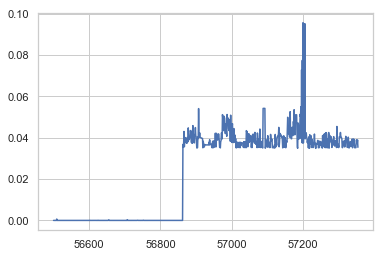

In [124]:
error_df.iloc[56500:,0].plot()

In [125]:
true_error = error_df[error_df['true_class']==0]
sorted_error = sorted(true_error['reconstruction_error'].values, reverse=True)
peaks = sorted_error[:20]

In [126]:
threshold_fixed = sorted_error[0] # np.mean(peaks)
threshold_fixed

0.004629669766798009

In [127]:
pred_y = [1 if e >= threshold_fixed else 0 for e in error_df.reconstruction_error.values]
print(classification_report(error_df.true_class, pred_y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       1.00      1.00      1.00       492

    accuracy                           1.00     57355
   macro avg       1.00      1.00      1.00     57355
weighted avg       1.00      1.00      1.00     57355

